In [ ]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

# pd.set_option("display.max_column", 999)
# print(os.listdir("../input"))

# Load the data!

In [1]:
# DATA_PATH = '../data/'

# tourney_results = pd.concat([
#     pd.read_csv(DATA_PATH + "mens/MNCAATourneyDetailedResults.csv"),
#     pd.read_csv(DATA_PATH + "womens/WNCAATourneyDetailedResults.csv"),
# ], ignore_index=True)

# seeds = pd.concat([
#     pd.read_csv(DATA_PATH + "mens/MNCAATourneySeeds.csv"),
#     pd.read_csv(DATA_PATH + "womens/WNCAATourneySeeds.csv"),
# ], ignore_index=True)

# regular_results = pd.concat([
#     pd.read_csv(DATA_PATH + "mens/MRegularSeasonDetailedResults.csv"),
#     pd.read_csv(DATA_PATH + "womens/WRegularSeasonDetailedResults.csv"),
# ], ignore_index=True)


In [2]:
# regular_results.groupby('Season').mean()

In [3]:
# tourney_results.groupby('Season').mean()

In [4]:
# all(regular_results.columns == tourney_results.columns)

# Data preparation!

In [5]:
# regular_results_swap = regular_results[[
#     'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
#     'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
#     'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [6]:
# regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
# regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
# regular_results.columns.values[6] = 'location'
# regular_results_swap.columns.values[6] = 'location'

In [7]:
# regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
# regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [8]:
# regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [9]:
"""
tourney_results = pd.read_csv('../input/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/WRegularSeasonDetailedResults.csv')
"""
DATA_PATH = '../data/'

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneyDetailedResults.csv"),
    # pd.read_csv(DATA_PATH + "womens/WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneySeeds.csv"),
    # pd.read_csv(DATA_PATH + "womens/WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MRegularSeasonDetailedResults.csv"),
    # pd.read_csv(DATA_PATH + "womens/WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

NameError: name 'pd' is not defined

In [ ]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature engineering!

In [ ]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [ ]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60275/1527646356.py:1: FutureWarning: The provided callable <function mean at 0x104f37d80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60275/1527646356.py:2: FutureWarning: The provided callable <function mean at 0x104f37d80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


In [ ]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [ ]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [ ]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [ ]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [ ]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [ ]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(12300, 5)

In [ ]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [ ]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

In [ ]:
np.exp(2)

7.38905609893065

In [ ]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024)
                         ]).reset_index(drop=True)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [ ]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [ ]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [ ]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [ ]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [ ]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [ ]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

In [ ]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2764.000000
mean        0.000000
std        14.548408
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [ ]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [ ]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [ ]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [ ]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [ ]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.48754+0.06821	test-mae:11.49643+0.27373


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:8.78616+0.08377	test-mae:9.16859+0.30140
[100]	train-mae:8.39280+0.09959	test-mae:9.12001+0.32404
[136]	train-mae:8.18353+0.10111	test-mae:9.11997+0.32364
Fold repeater 1
[0]	train-mae:11.48884+0.11032	test-mae:11.49717+0.45757


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:8.79456+0.08254	test-mae:9.13488+0.37397
[100]	train-mae:8.41053+0.08230	test-mae:9.07794+0.39693
[141]	train-mae:8.18247+0.08563	test-mae:9.08240+0.40496
Fold repeater 2
[0]	train-mae:11.48163+0.10018	test-mae:11.49088+0.41553


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:8.78800+0.04891	test-mae:9.16353+0.28422
[100]	train-mae:8.39644+0.05215	test-mae:9.12076+0.27238
[150]	train-mae:8.11583+0.05871	test-mae:9.10379+0.25924
[153]	train-mae:8.09988+0.05993	test-mae:9.09643+0.26070


In [ ]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([111, 116, 128], [9.11535513538968, 9.074881460633376, 9.095607706989899])

In [ ]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60275/4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 20.31013      8.555341     9.241185    -8.725495    10.817025
   2.5168228   -2.4273133   13.184846     3.1828935   -1.4074564
   0.37973863   0.23135135  20.29529     -2.0488331   20.310392
  11.191801     9.568615     3.8403723    2.3879807   -1.8851684
   4.5553803    8.634601     1.1611943    1.4320945   -1.0454407
   4.474085    16.13766      8.509378    14.953941    11.180107
  -2.529024    -2.0428097    8.190321     0.12192408  -1.6013396
  18.743282    10.473167    -6.9506736   -0.9015677   -4.7452593
   1.8057574    8.312766    10.44622     1

Fold repeater 1


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60275/4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.48686767e-01  1.51512861e+01 -2.34459543e+00  9.71573639e+00
  9.98002052e+00  8.48568630e+00  3.14053798e+00  5.68611670e+00
  1.11318092e+01  4.09756422e+00 -6.74330950e+00 -4.33414459e-01
  2.40730972e+01  1.63227391e+00  1.08917637e+01  1.26868933e-01
  4.65395641e+00  4.93292379e+00 -6.86257887e+00 -7.92653263e-01
  4.74745929e-01 -1.75850201e+00 -4.38308191e+00 -2.40733910e+00
  1.25670948e+01 -3.60415697e+00  6.54451466e+00  1.97829634e-01
  7.62220049e+00 -2.07200384e+00  7.70763159e+00  2.06183624e+01
  7.88370323e+00  1.21886616e+01  1.658

Fold repeater 2


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60275/4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -0.47921503   9.776451    -5.3325343   -3.908729    -2.166966
   1.6189686    7.3869023    9.066413     4.4623966   -0.96835834
  -7.149077    18.936129    20.901957     0.13256565  20.541927
   1.8078144    9.923088     7.075652     3.6029751    4.531693
   8.5558815    7.783878    -1.1933728    3.0033996    4.4734163
  -5.3655386   -0.21636519  -4.922932    -1.2294894    6.2730103
   9.985251     5.0285935    4.2033005   -3.5594752    2.8326907
  23.343288     5.148904     2.4041665    6.7592683    2.370741
   6.6477103    7.618315    -1.4918582    

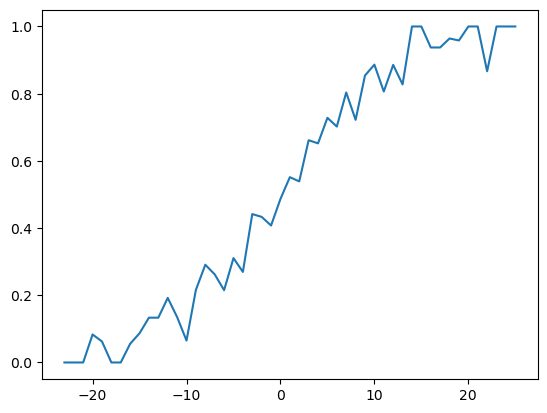

In [ ]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [ ]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5561828011385489
logloss of cvsplit 1: 0.5553487026745254
logloss of cvsplit 2: 0.559746034204258


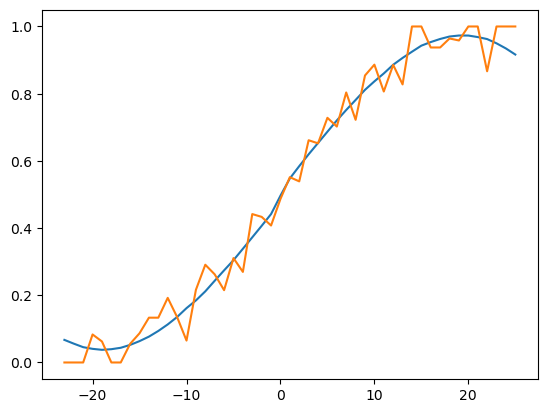

In [ ]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [ ]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5561828011385489
adjusted logloss of cvsplit 1: 0.5553487026745254
adjusted logloss of cvsplit 2: 0.5597733835672969


In [ ]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.4430940935609413
adjusted logloss of cvsplit 1: 1.4423434440211207
adjusted logloss of cvsplit 2: 1.4461198828053738


In [ ]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
2396,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,...,6.258065,2.806452,1.516129,1.000000,1.000000,1.925680e+15,-2.631836e+15,1,16,-15
2653,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,...,5.593750,3.875000,0.312500,1.000000,0.666667,-1.092300e-01,-2.639244e+01,1,16,-15
1987,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,...,5.687500,3.843750,10.218750,0.500000,1.000000,1.634525e+00,-2.436592e+01,2,15,-13
1990,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,...,6.593750,3.125000,2.812500,1.000000,1.000000,2.093895e+00,-2.397960e+01,2,15,-13
2050,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,...,6.937500,3.031250,5.031250,0.500000,1.000000,1.605392e+00,4.409391e-01,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,2019,137,1414,70,1243,64,26.941176,58.970588,6.794118,18.882353,...,6.181818,2.848485,6.575758,1.000000,0.750000,2.286790e+01,2.467411e+01,13,4,9
1125,2021,137,1317,78,1345,69,25.080000,53.280000,7.400000,19.840000,...,5.592593,3.444444,4.814815,0.666667,0.666667,-3.568856e+14,3.819878e+15,13,4,9
1146,2021,138,1325,62,1438,58,29.545455,60.681818,8.590909,23.500000,...,5.125000,2.333333,8.166667,1.000000,1.000000,1.817673e+15,7.237719e+15,13,4,9
1256,2023,136,1202,68,1438,67,28.000000,58.774194,9.387097,27.290323,...,4.843750,3.750000,7.562500,1.000000,0.800000,-2.615295e+01,-1.405622e+00,13,4,9


In [ ]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5302715547942882
adjusted logloss of cvsplit 1: 0.5294723732616025
adjusted logloss of cvsplit 2: 0.5325081579841829


In [ ]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5302715547942882
adjusted logloss of cvsplit 1: 0.5294723732616025
adjusted logloss of cvsplit 2: 0.5325081579841829


/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60275/1651078057.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.521478
2004    0.485565
2005    0.476953
2006    0.541777
2007    0.418023
2008    0.456249
2009    0.460219
2010    0.538534
2011    0.575106
2012    0.558115
2013    0.585200
2014    0.581225
2015    0.505490
2016    0.551488
2017    0.486460
2018    0.581462
2019    0.479845
2021    0.571729
2022    0.636951
2023    0.585694
2024    0.533267
dtype: float64

# Submission time!

In [ ]:

# sub["Season"] = 2018
# sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
# sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
# sub.head()

sub = pd.read_csv(DATA_PATH + "SampleSubmissionStage1.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2021_1101_1102,0.5,2021,1101,1102
1,2021_1101_1103,0.5,2021,1101,1103
2,2021_1101_1104,0.5,2021,1101,1104
3,2021_1101_1105,0.5,2021,1101,1105
4,2021_1101_1106,0.5,2021,1101,1106


In [ ]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2021_1101_1102,0.5,2021,1101,1102,27.173913,59.043478,8.130435,21.565217,9.608696,...,6.000000,2.120000,-13.200000,3.173641e+15,NaN,14.0,NaN,1.0,0.000000,NaN
1,2021_1101_1103,0.5,2021,1101,1103,27.173913,59.043478,8.130435,21.565217,9.608696,...,5.714286,2.428571,3.809524,3.173641e+15,NaN,14.0,NaN,1.0,0.333333,NaN
2,2021_1101_1104,0.5,2021,1101,1104,27.173913,59.043478,8.130435,21.565217,9.608696,...,8.000000,4.833333,9.800000,3.173641e+15,4.899430e+15,14.0,2.0,1.0,1.000000,12.0
3,2021_1101_1105,0.5,2021,1101,1105,27.173913,59.043478,8.130435,21.565217,9.608696,...,8.066667,2.666667,-3.866667,3.173641e+15,NaN,14.0,NaN,1.0,0.000000,NaN
4,2021_1101_1106,0.5,2021,1101,1106,27.173913,59.043478,8.130435,21.565217,9.608696,...,7.722222,4.166667,-7.333333,3.173641e+15,NaN,14.0,NaN,1.0,0.000000,NaN


In [ ]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [ ]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1
Fold repeater 2


In [ ]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [ ]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""

"\ntourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')\ntourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)\ntourney_results2018.columns = ['ID', 'label']\ntourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')\nlog_loss(tourney_results2018.label, tourney_results2018.Pred)\n"